Imports

In [2]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # for visualisation
import numpy as np


from sklearn.pipeline import Pipeline

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier



from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import random
random.seed(15)

# Default plotting parameters
font = {'size'   : 18}
plt.rc('font', **font)

In [3]:
# Function to format the predictions in a dataframe and export to a csv file, to be uploaded on kaggle
def export_to_csv(y_hat, filename):
    df = pd.DataFrame({'Genre': y_hat})
    df.index.name = 'Id'
    df.to_csv(filename)

In [4]:
# Load training dataset
rep = 'data/' # repertory where the data are stored in practical folder
y_train = pd.read_csv(rep + 'y_train.csv', index_col = 0, squeeze=True)
X_train = pd.read_csv(rep + 'X_train.csv', index_col = 0, header=[0, 1, 2]) #sets up header to be tuple
X_test = pd.read_csv(rep + 'X_test.csv', index_col = 0, header=[0, 1, 2])


#Create version with them together
Xy = pd.concat([X_train, y_train], axis = 1)

#standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Overall Functions

In [7]:
def KNN_grid_search(clf, X, y, cv, max_k):
    #Grid Search      
    grid = dict()
    grid['n_neighbors'] = np.arange(1,max_k) 
    # define search
    search = GridSearchCV(clf, grid, scoring='accuracy', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(X, y)
    print('Mean Validation Accuracy: %.3f' % results.best_score_)      
    print('Config: %s' % results.best_params_)
    return(results)

# K Nearest Neighbors for untransformed data

Grid search. Performance isn't great. Very slow to do this on unprojected data, larger grid search not feasible

In [8]:
#Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X_train_sc, y_train , test_size = 0.20 , random_state=15)

KNN = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2) #p=2 euclidean, p=1 L1
cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 1, random_state = 25)
#will give splits of 1200 -- about size of our test set

KNN_grid_search(KNN, X_tr, y_tr, cv, 10)

Mean Validation Accuracy: 0.467
Config: {'n_neighbors': 4}


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=4, random_state=25),
             estimator=KNeighborsClassifier(n_neighbors=1, p=1), n_jobs=-1,
             param_grid={'n_neighbors': array([1, 2, 3, 4])},
             scoring='accuracy')

Training this on the full training set from train-test split above

In [9]:
k = 7
KNN = KNeighborsClassifier(n_neighbors = k, metric = 'minkowski', p = 2) #p=2 euclidean, p=1 L1      
KNN.fit(X_tr,y_tr)
KNN.score(X_te,y_te) 

0.4608333333333333

# KNN while first projecting the data onto LDA discriminant coordinates 

1. Fit LDA projections on X_tr
2. Transform 
3. Do cross validation for KNN
4. Learn final KNN model on training data
5. Apply LDA projection to held-out validation set and then apply KNN to that

*note: scaled vs not didn't seem to make a difference

In [11]:
#Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X_train_sc, y_train , test_size = 0.20 , random_state=15)

#Fit LDA projections on training data, obtain projections for both train and test
LDA = LinearDiscriminantAnalysis(n_components = 7)
LDA.fit(X_tr, y_tr)
Z_tr = LDA.transform(X_tr)
Z_te = LDA.transform(X_te)

In [12]:
#cross validation for KNN
KNN = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 1, random_state = 25)
#will give splits of 1200 -- about size of our test set

results = KNN_grid_search(KNN, Z_tr, y_tr, cv, 100)

Mean Validation Accuracy: 0.705
Config: {'n_neighbors': 59}


0.5508333333333333


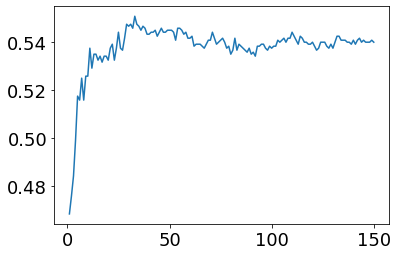

In [136]:
nk = 150
kval = np.arange(1,nk+1)
KNN_acc = np.zeros(nk)

for i,k in enumerate(kval):
    KNN = KNeighborsClassifier(n_neighbors = k)        
    KNN.fit(Z_tr,y_tr)
    KNN_acc[i] = KNN.score(Z_te,y_te) 
    
print(np.max(KNN_acc))
plt.plot(kval, KNN_acc)

In [13]:
#Fit n_neighbors = 59 from crossval
KNN = KNeighborsClassifier(n_neighbors = 59)        
KNN.fit(Z_tr,y_tr)
KNN.score(Z_te,y_te) 

0.5416666666666666

Applying this to full data

In [14]:
#Fit LDA projections on training data, obtain projections for both train and test
LDA = LinearDiscriminantAnalysis(n_components = 7)
LDA.fit(X_train_sc, y_train)
Z_train = LDA.transform(X_train_sc)
Z_test = LDA.transform(X_test_sc)

#fit KNN model on training data
KNN = KNeighborsClassifier(n_neighbors = 59)
KNN.fit(Z_train,y_train)
print("Training accuracy:", KNN.score(Z_train,y_train))
#obtain predictions
y_vals = KNN.predict(Z_test)

Training accuracy: 0.6936666666666667


In [15]:
#export_to_csv(y_vals, "KNN_Predictions1.csv")

# Experimenting with quantile transforms

https://machinelearningmastery.com/quantile-transforms-for-machine-learning/

https://machinelearningmastery.com/linear-discriminant-analysis-for-dimensionality-reduction-in-python/

Overall, normal seems to do slightly better

In [16]:
# define pipeline
trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
LDA = LinearDiscriminantAnalysis(n_components = 7)
model = KNeighborsClassifier(n_neighbors = 62)

pipeline = Pipeline(steps=[('t', trans), ('lda', LDA), ('m', model)])

# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

np.mean(n_scores)

0.5645

In [17]:
#Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X_train_sc, y_train , test_size = 0.20 , random_state=15)
pipeline.fit(X_tr,y_tr)
pipeline.score(X_te, y_te)

0.5558333333333333

On the full data

In [18]:
pipeline.fit(X_train,y_train)
y_vals2 = pipeline.predict(X_test)

In [20]:
#export_to_csv(y_vals2, "KNN_Predictions2.csv")

**Sanity Check: Doing Stuff Manually and incorporating a grid search**

In [21]:
#Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X_train_sc, y_train , test_size = 0.20 , random_state=15)

#Scale - normal 
scaler2 = QuantileTransformer(n_quantiles=100, output_distribution='normal')
scaler2.fit(X_tr)
X_tr_sc2 = scaler2.transform(X_tr)
X_te_sc2 = scaler2.transform(X_te)

#Scale - uniform
scaler3 = QuantileTransformer(n_quantiles=100, output_distribution='uniform')
scaler3.fit(X_tr)
X_tr_sc3 = scaler3.transform(X_tr)
X_te_sc3 = scaler3.transform(X_te)

LDA, Grid Search, and fit on test for normal scaled data

In [22]:
#For Normal Scaled data
LDA = LinearDiscriminantAnalysis(n_components = 7)
LDA.fit(X_tr_sc2, y_tr)
Z_tr = LDA.transform(X_tr_sc2)
Z_te = LDA.transform(X_te_sc2)

In [23]:
#Grid search
KNN = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 2, random_state = 25)
results = KNN_grid_search(KNN, Z_tr, y_tr, cv, 100)

Mean Validation Accuracy: 0.714
Config: {'n_neighbors': 62}


In [24]:
#KNN
KNN = KNeighborsClassifier(n_neighbors = 62)        
KNN.fit(Z_tr,y_tr)
KNN.score(Z_te,y_te) 

0.5558333333333333

LDA, Grid search, and fit on test for uniform scaled data

In [145]:
#For uniform Scaled data
LDA = LinearDiscriminantAnalysis(n_components = 7)
LDA.fit(X_tr_sc3, y_tr)
Z_tr = LDA.transform(X_tr_sc3)
Z_te = LDA.transform(X_te_sc3)

In [146]:
#Grid search
KNN = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 1, random_state = 25)
results = KNN_grid_search(KNN, Z_tr, y_tr, cv, 100)

Mean Validation Accuracy: 0.710
Config: {'n_neighbors': 94}


In [147]:
#KNN
KNN = KNeighborsClassifier(n_neighbors = 94)        
KNN.fit(Z_tr,y_tr)
KNN.score(Z_te,y_te) 

0.5491666666666667

Doing Normal procedure on the full data

In [26]:
scaler4 = QuantileTransformer(n_quantiles=100, output_distribution='normal')
scaler4.fit(X_train)
X_tr_sc4 = scaler4.transform(X_train)
X_te_sc4 = scaler4.transform(X_test)

LDA = LinearDiscriminantAnalysis(n_components = 7)
LDA.fit(X_tr_sc4, y_train)
Z_tr = LDA.transform(X_tr_sc4)
Z_te = LDA.transform(X_te_sc4)

#KNN
KNN = KNeighborsClassifier(n_neighbors = 62)        
KNN.fit(Z_tr,y_train)
y_vals3 = KNN.predict(Z_te)

#export_to_csv(y_vals3, "KNN_Predictions3.csv")

In [27]:
#comparing predictions- as per 'sanity check', last 2 agree perfectly
print(np.sum(np.equal(y_vals2, y_vals))/2000)
print(np.sum(np.equal(y_vals3, y_vals))/2000)
print(np.sum(np.equal(y_vals2, y_vals3))/2000)

0.758
0.758
1.0


# Varying Distance Metric

Try L1 Distance with Standard Scaler

In [11]:
#Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X_train_sc, y_train , test_size = 0.20 , random_state=15)

#Fit LDA projections on training data, obtain projections for both train and test
LDA = LinearDiscriminantAnalysis(n_components = 7)
LDA.fit(X_tr, y_tr)
Z_tr = LDA.transform(X_tr)
Z_te = LDA.transform(X_te)

In [12]:
#cross validation for KNN
KNN = KNeighborsClassifier(metric = 'minkowski', p = 1)
cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 1, random_state = 25)
#will give splits of 1200 -- about size of our test set

results = KNN_grid_search(KNN, Z_tr, y_tr, cv, 100)

Mean Validation Accuracy: 0.702
Config: {'n_neighbors': 88}


In [13]:
KNN = KNeighborsClassifier(n_neighbors = 88)        
KNN.fit(Z_tr,y_tr)
KNN.score(Z_te,y_te) 

0.5358333333333334

Try L1 distance with quadratic scaler

In [14]:
# define pipeline
trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
LDA = LinearDiscriminantAnalysis(n_components = 7)
model = KNeighborsClassifier(n_neighbors = 88, metric = "minkowski", p = 1)

pipeline = Pipeline(steps=[('t', trans), ('lda', LDA), ('m', model)])

# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

np.mean(n_scores)

0.5628888888888889

Grid search over distance metrics (p=1 to 10) and n_neighbors (1 to 100) (Standard Scaler) indicates 2 does best (what was already doing)

In [17]:
KNN = KNeighborsClassifier(metric = 'minkowski', p = 1)
cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 1, random_state = 25)

#Grid Search      
grid = dict()
grid['n_neighbors'] = np.arange(1,100) 
grid['p'] = np.arange(1,10) 
# define search
search = GridSearchCV(KNN, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(Z_tr, y_tr)
print('Mean Validation Accuracy: %.3f' % results.best_score_)      
print('Config: %s' % results.best_params_)


Mean Validation Accuracy: 0.705
Config: {'n_neighbors': 59, 'p': 2}
